In [245]:
%matplotlib inline
import gzip
import pickle
import os
import struct

from math import floor, sqrt, ceil

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from scipy import optimize as opt
from scipy.io import loadmat

training_set_label_file = 'data/train-labels-idx1-ubyte.gz'
training_set_image_file = 'data/train-images-idx3-ubyte.gz'
test_set_label_file = 'data/t10k-labels-idx1-ubyte.gz'
test_set_image_file = 'data/t10k-images-idx3-ubyte.gz'

def read_data(label_file, image_file):  
    with gzip.open(training_set_label_file, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromstring(f.read(), dtype=np.uint8)

    with gzip.open(training_set_image_file, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromstring(f.read(), dtype=np.uint8).reshape(num, rows * cols)
    
    return labels, images, rows, cols

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))


def feedforward(X, theta1, theta2):
    # Feedforward
    m, n = X.shape  # m = 5000, n = 400
    a1 = np.append(np.ones((m, 1)), X, axis=1)  # a1: 5000 x 401
    z2 = a1.dot(theta1.T)  # z2: 5000 x 25
    a2 = np.append(np.ones((m, 1)), sigmoid(z2), axis=1)  # a2: 5000 x 26
    z3 = a2.dot(theta2.T)  # z3: 5000 x 10
    a3 = sigmoid(z3)  # a3: 5000 x 10
    h = a3
    return h, a1, z2, a2, z3


def cost_func(nn_params, input_layer_size, hidden_layer_size, num_labels,
              X, y, lamb):
    m, n = X.shape  # m = 5000, n = 400
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].copy()
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))

    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].copy()
    theta2 = theta2.reshape((num_labels, hidden_layer_size + 1))

    encoder = OneHotEncoder(sparse=False)
    y_mat = encoder.fit_transform(y)

    h, a1, z2, a2, z3 = feedforward(X, theta1, theta2)

    J = -1/m*(np.sum(y_mat * np.log(h))+np.sum((1-y_mat) * np.log(1-h)))

    # Regularize
    regular_term = np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2)
    regular_term = lamb / (2 * m) * regular_term
    J += regular_term

    return J


def back_propagation(nn_params, input_layer_size, hidden_layer_size,
                     num_labels, X, y, lamb):
    # Backpropagation
    m, n = X.shape  # m = 5000, n = 400
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].copy()
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))

    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].copy()
    theta2 = theta2.reshape((num_labels, hidden_layer_size + 1))

    encoder = OneHotEncoder(sparse=False)
    y_mat = encoder.fit_transform(y)

    h, a1, z2, a2, z3 = feedforward(X, theta1, theta2)

    d3 = h - y_mat
    d2 = d3.dot(theta2[:, 1:]) * sigmoid_gradient(z2)
    delta1 = d2.T.dot(a1)
    delta2 = d3.T.dot(a2)
    theta1_grad = delta1 / m
    theta2_grad = delta2 / m

    theta1[:, 0] = 0
    theta2[:, 0] = 0
    theta1_grad += theta1 * lamb / m
    theta2_grad += theta2 * lamb / m

    grad = np.append(theta1_grad.flatten(), theta2_grad.flatten())
    return grad


def rand_init_weights(lin, lout):
    init_e = 0.12
    w = np.random.random_sample((lout, lin + 1)) * 2 * init_e - init_e
    return w


def predict(theta1, theta2, X):
    m, n = X.shape

    h1 = sigmoid(np.append(np.ones((m, 1)), X, axis=1).dot(theta1.T))
    h2 = sigmoid(np.append(np.ones((m, 1)), h1, axis=1).dot(theta2.T))

    hypothesis = np.argmax(h2, axis=1)

    return hypothesis


def callback(nn_params):
    global iter_times
    global costs
    iter_times += 1
    J = cost_func(nn_params, input_layer_size, hidden_layer_size,
                  num_labels, X, y, lamb)
    costs.append((iter_times, J))
    if iter_times % 10 == 0:
        print('Iteration {:>4d}| Cost: {:.6f}'.format(iter_times, J))

In [243]:
y, X, height, width = read_data(training_set_label_file, training_set_image_file)
y = y.reshape((-1, 1))

y_test, X_test, height, width = read_data(test_set_label_file, test_set_image_file)
y_test = y_test.reshape((-1, 1))

input_layer_size = height * width
hidden_layer_size = 200
num_labels = 10

m, n = X.shape
print('Training set size: {} x {}'.format(m, n))
print('Image pixels: {} x {}'.format(height, width))

Training set size: 60000 x 784
Image pixels: 28 x 28


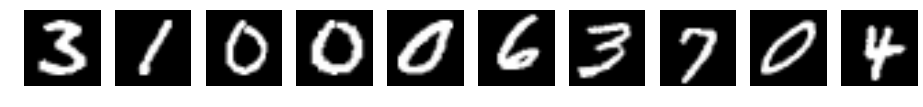

Labels:  [3 1 0 0 0 6 3 7 0 4]


In [194]:
plt.figure(figsize=(16, 16))
sel = np.random.choice(m, 10, replace=False)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[sel[i]].reshape((height, width)), cmap='gray')
    plt.axis('off')
plt.show()
print('Labels: ', y[sel].ravel())

In [246]:
lamb = 1
iter_times = 0
initial_theta1 = rand_init_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_init_weights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_theta1, initial_theta2)

print('Traing Neural Network...')
options = {'full_output': True, 'maxiter': 100, 'callback': callback}

costs = []
nn_params, cost, *rest = opt.fmin_cg(
    cost_func, x0=initial_nn_params, fprime=back_propagation,
    args=(input_layer_size, hidden_layer_size,
          num_labels, X, y, lamb), **options)

theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].copy()
theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))

theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].copy()
theta2 = theta2.reshape((num_labels, hidden_layer_size + 1))

Traing Neural Network...


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: overflow encountered in exp


Iteration   10| Cost: 1.019749
Iteration   20| Cost: 0.644647
Iteration   30| Cost: 0.531697
Iteration   40| Cost: 0.470559
Iteration   50| Cost: 0.423230
Iteration   60| Cost: 0.396923
Iteration   70| Cost: 0.385062
Iteration   80| Cost: 0.375892
Iteration   90| Cost: 0.366944
Iteration  100| Cost: 0.361437
         Current function value: 0.361437
         Iterations: 100
         Function evaluations: 129
         Gradient evaluations: 129


Visualizing Learning Curves...


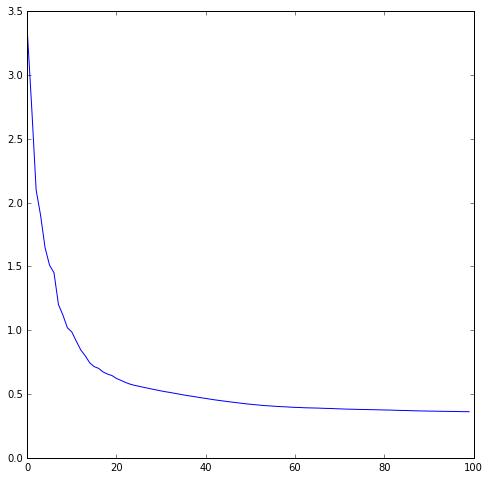

Start Predicting on Training set...


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: overflow encountered in exp


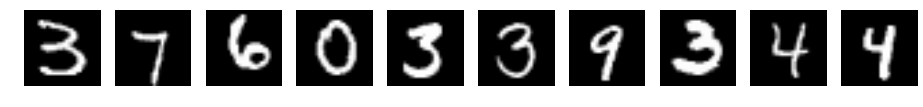

Labels:  [3 7 6 0 3 3 9 3 4 4]
Predict:  [3 7 6 0 3 3 9 3 4 4]
Training Set Accurary: 95.05%
Start Predicting on Test set...


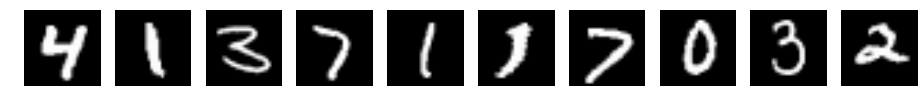

Labels:  [4 1 3 7 1 1 7 0 3 2]
Predict:  [4 1 3 7 1 1 7 0 3 2]
Test Set Accurary: 95.05%


In [247]:
print('Visualizing Learning Curves...')
plt.figure(figsize=(8, 8))
js = [cost for iteration, cost in costs]
plt.plot(js)
plt.show()

print('Start Predicting on Training set...')
h = predict(theta1, theta2, X).reshape((-1, 1))

plt.figure(figsize=(16, 16))
sel = np.random.choice(m, 10, replace=False)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[sel[i]].reshape((height, width)), cmap='gray')
    plt.axis('off')
plt.show()
print('Labels: ', y[sel].ravel())
print('Predict: ', h[sel].ravel())
print('Training Set Accurary: {:.2%}'.format(np.sum(h == y) / m))

print('Start Predicting on Test set...')
h = predict(theta1, theta2, X_test).reshape((-1, 1))
plt.figure(figsize=(16, 16))
sel = np.random.choice(m, 10, replace=False)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[sel[i]].reshape((height, width)), cmap='gray')
    plt.axis('off')
plt.show()
print('Labels: ', y[sel].ravel())
print('Predict: ', h[sel].ravel())
print('Test Set Accurary: {:.2%}'.format(np.sum(h == y_test) / X_test.shape[0]))